In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# solve_eq = 'gs' # gs or heat
solve_eq = 'gs'


In [23]:
eps_1 = {'heat': 1e-5, 'gs': 0.14}
eps_2 = {'heat': 1e-4, 'gs': 0.06}

n_x = {'heat': 64, 'gs': 256}
x_start = {'heat': 0, 'gs': 0}
x_end = {'heat': 0.63, 'gs': 255}
x_arr = np.linspace(x_start[solve_eq], x_end[solve_eq], n_x[solve_eq])
dx = np.diff(x_arr)[0]

n_y = {'heat': 64, 'gs': 256}
y_start = {'heat': 0, 'gs': 0}
y_end = {'heat': 0.63, 'gs': 255}
y_arr = np.linspace(y_start[solve_eq], y_end[solve_eq], n_y[solve_eq])
dy = np.diff(y_arr)[0]

# dt_set = 0.9 * (dx ** 2) / (4 * eps_1[solve_eq])
# n_times = {'heat': 501, 'gs': 2000}
# t_start = {'heat': 0, 'gs': 0}
# t_end = {'heat': 6e-1, 'gs': 5}

# dt_set = 0.9 * (dx ** 2) / (4 * eps_1[solve_eq])
n_times = {'heat': 501, 'gs': 8000}  # int(100 / (8 * dt_set)) * 8
t_start = {'heat': 0, 'gs': 0}
t_end = {'heat': 100, 'gs': 7999}
t_arr = np.linspace(t_start[solve_eq], t_end[solve_eq], n_times[solve_eq])
dt = np.diff(t_arr)[0]

u_mat = np.ones((n_x[solve_eq], n_y[solve_eq]))
v_mat = np.zeros((n_x[solve_eq], n_y[solve_eq]))

if solve_eq == 'heat':
    u_mat[40:60, 40:60] = 0.5
elif solve_eq == 'gs':
    # http://www.u.arizona.edu/~erdmann/mse350/_downloads/gray_scott_reaction_diffusion.pdf

    spat_slice = slice(int(7/16 * n_x[solve_eq]), int(9/16 * n_x[solve_eq]))
    u_mat[spat_slice, spat_slice] = 0.5
    v_mat[spat_slice, spat_slice] = 0.25
    u_mat[:, :] += ((np.random.rand(n_x[solve_eq], n_y[solve_eq]) - 0.5) * 0.02)
    v_mat[:, :] += ((np.random.rand(n_x[solve_eq], n_y[solve_eq]) - 0.5) * 0.02)

    interaction = True
    decay = True
    F, k = 0.035, 0.065  # spots
#     F, k = 0.02, 0.05  # maze
#     F, k = 0.035, 0.06

In [24]:
def diffusion_update(old_u, diff_coef=1):
    """Perform numerical 2D laplacian update (via central finite difference)"""
    diff = np.zeros_like(old_u)
    diff = diff_coef * (((np.roll(old_u, shift=1, axis=0) 
                            + np.roll(old_u, shift=-1, axis=0) 
                            - 2 * old_u) / (dx ** 2)) 
                            + ((np.roll(old_u, shift=1, axis=1)
                            + np.roll(old_u, shift=-1, axis=1)
                            - 2 * old_u) / (dy ** 2)))
    return diff

In [25]:
def update_uv(old_u_mat, old_v_mat):
    new_u_mat = old_u_mat.copy()
    new_v_mat = old_v_mat.copy() 
    
    new_u_mat += dt * diffusion_update(old_u=old_u_mat, diff_coef=eps_1[solve_eq])
    new_v_mat += dt * diffusion_update(old_u=old_v_mat, diff_coef=eps_2[solve_eq])
    
    if solve_eq == 'gs':
        if interaction:
            uvv = old_u_mat * np.power(old_v_mat, 2)
            new_u_mat -= dt * uvv
            new_v_mat += dt * uvv
        
        if decay:
            new_u_mat += dt * F * (1 - old_u_mat)
            new_v_mat -= dt * (k + F) * old_v_mat

    return new_u_mat, new_v_mat

In [26]:
print(solve_eq)
for i_tau in tqdm(range(n_times[solve_eq] - 1)):
    old_u = u_mat.copy()
    old_v = v_mat.copy()
    u_mat, v_mat = update_uv(old_u_mat=old_u, old_v_mat=old_v)

  0%|          | 31/7999 [00:00<00:25, 307.96it/s]

gs


100%|██████████| 7999/7999 [00:21<00:00, 378.32it/s]


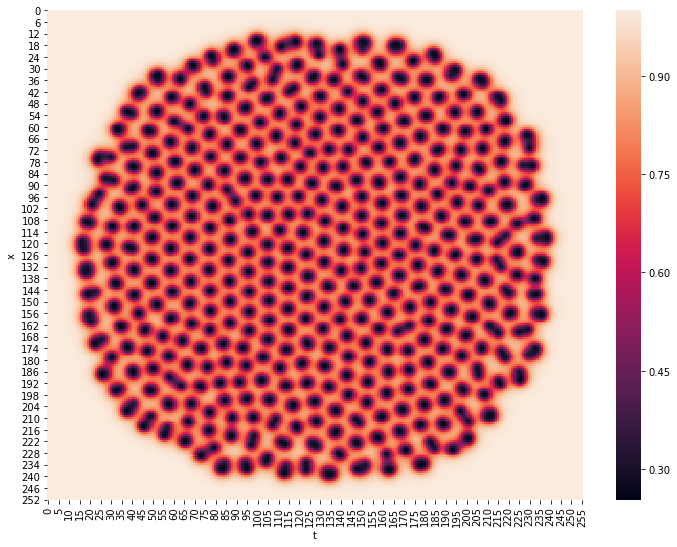

In [27]:
plt.rcParams['figure.figsize'] = (12, 9)
sns.heatmap(u_mat); plt.xlabel('t'); plt.ylabel('x');